In [1]:
import os, time, copy, glob, cv2, shutil

import torch
import torchvision
import torchvision.transforms as transforms # 데이터 전처리
import torchvision.models as models # 다양한 파이토치 네트워크 제공
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader
import numpy as np 

import matplotlib.pyplot as plt

In [2]:
data_path = 'data/catanddog/train'

# 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환
transform = transforms.Compose([
                transforms.Resize([256,256]),       # 이미지 크기 조정: 합성곱층을 통과하기 위해 이미지 크기 조정
                transforms.RandomResizedCrop(224),  # 이미지를 랜덤한 비율로 자른 후 데이터 크기 조정: 데이터 확장                  
                transforms.RandomHorizontalFlip(),  # 이미지를 랜덤하게 수평으로 뒤집음
                transforms.ToTensor()
            ])

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True) #num_workers => 데이터를 불러올때 하위 프로세스를 몇 개 사용할지 설정 

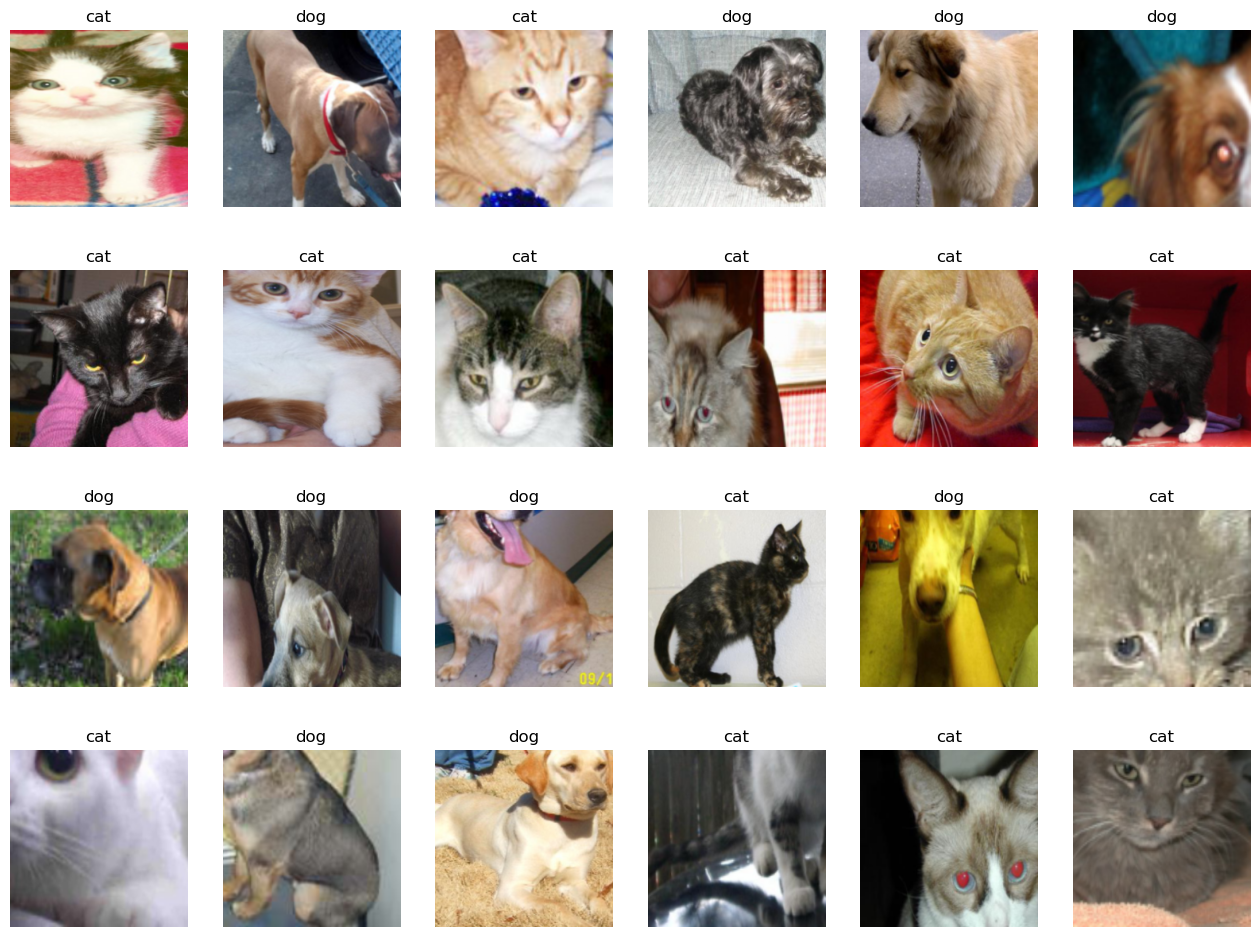

In [3]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}

fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0))) # 크기 변환
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [3]:
resnet18 = models.resnet18(pretrained=True)

In [4]:
# 파라메터의 대해서는 학습을 하지 않도록 고정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    
set_parameter_requires_grad(resnet18)

In [5]:
# ResNet18의 마지막 부분에 완전 연결층 추가
resnet18.fc = nn.Linear(512, 2) # 2개의 클래스 분류

In [6]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        
print(resnet18)

fc.weight tensor([[-0.0247,  0.0048, -0.0076,  ...,  0.0248,  0.0142, -0.0138],
        [-0.0044,  0.0104,  0.0244,  ...,  0.0204, -0.0230,  0.0379]])
fc.bias tensor([0.0093, 0.0142])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_

In [7]:
model = models.resnet18(pretrained=True)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False
    
# 완전연결층은 학습
model.fc = nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def train_model(model, dataloaders, loss_fn, optimizer, device, num_epochs=13,is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수 
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            pred = model(inputs)
            _, preds = torch.max(pred, 1)
            loss = loss_fn(pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장 
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
            
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
        
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        loss_history.append(epoch_loss)    
        acc_history.append(epoch_acc.item())
        
        torch.save(model.state_dict(), os.path.join('data/catanddog/', f'{epoch:0=2d}.pth'))
        print()
        
    time_elapsed = time.time() - since # 학습 시간 계산
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')
    return acc_history, loss_history
        

In [9]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) # 파라메터 학습 결과 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model, train_loader, loss_fn, optimizer, device)

Epoch 0/13
----------


c:\Users\Hyeonseok\anaconda3\envs\torch_study\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 0.5534 Acc: 0.7117

Epoch 1/13
----------
Loss: 0.3663 Acc: 0.8442

Epoch 2/13
----------
Loss: 0.3333 Acc: 0.8545

Epoch 3/13
----------
Loss: 0.2567 Acc: 0.8987

Epoch 4/13
----------
Loss: 0.2645 Acc: 0.8961

Epoch 5/13
----------
Loss: 0.2413 Acc: 0.9091

Epoch 6/13
----------
Loss: 0.2475 Acc: 0.9013

Epoch 7/13
----------
Loss: 0.2268 Acc: 0.9013

Epoch 8/13
----------
Loss: 0.2115 Acc: 0.9221

Epoch 9/13
----------
Loss: 0.2188 Acc: 0.9169

Epoch 10/13
----------
Loss: 0.2155 Acc: 0.9065

Epoch 11/13
----------
Loss: 0.1825 Acc: 0.9273

Epoch 12/13
----------
Loss: 0.1757 Acc: 0.9247

Training complete in 3m 33s
Best Acc: 0.927273


In [41]:
test_path = 'data/catanddog/test'

transform = transforms.Compose([
                transforms.Resize(224),       
                transforms.CenterCrop(224),            
                transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

print(len(test_dataset))

98


In [18]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob('data/catanddog/' + '*.pth') # 현재 디렉토리에서 원하는 파일들만 추출하여 가져올때 사용
    saved_models.sort()
    print('saved_model', saved_models)
    
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                pred = model(inputs)
                
                _, preds = torch.max(pred.data, 1) # 주어진 텐서 배열의 최댓값이 들어있는 index 반환
                preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
                preds[preds < 0.5] = 0  # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측 
                running_corrects += preds.eq(labels.cpu()).int().sum() # preds 배열과 labels가 일치하는지 검사, 모델의 예측 결과와 레이블이 일치하는 것들의 개수 합  
                
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')
    return acc_history

In [19]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['data/catanddog\\00.pth', 'data/catanddog\\01.pth', 'data/catanddog\\02.pth', 'data/catanddog\\03.pth', 'data/catanddog\\04.pth', 'data/catanddog\\05.pth', 'data/catanddog\\06.pth', 'data/catanddog\\07.pth', 'data/catanddog\\08.pth', 'data/catanddog\\09.pth', 'data/catanddog\\10.pth', 'data/catanddog\\11.pth', 'data/catanddog\\12.pth']
Loading model data/catanddog\00.pth
Acc: 0.9082

Loading model data/catanddog\01.pth
Acc: 0.9388

Loading model data/catanddog\02.pth
Acc: 0.8980

Loading model data/catanddog\03.pth
Acc: 0.9490

Loading model data/catanddog\04.pth
Acc: 0.9082

Loading model data/catanddog\05.pth
Acc: 0.9286

Loading model data/catanddog\06.pth
Acc: 0.9082

Loading model data/catanddog\07.pth
Acc: 0.9694

Loading model data/catanddog\08.pth
Acc: 0.9184

Loading model data/catanddog\09.pth
Acc: 0.9490

Loading model data/catanddog\10.pth
Acc: 0.9082

Loading model data/catanddog\11.pth
Acc: 0.9184

Loading model data/catanddog\12.pth
Acc: 0.9592

Training com

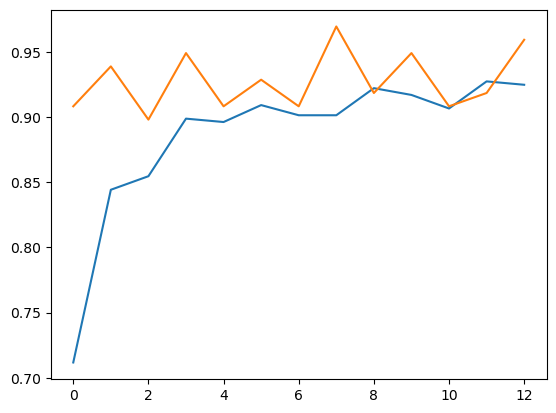

In [20]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

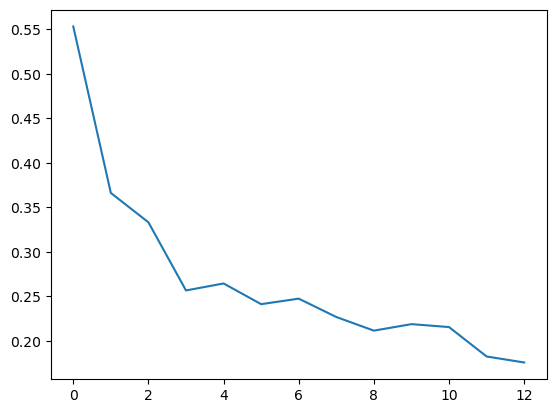

In [21]:
plt.plot(train_loss_hist)
plt.show()

In [23]:
# 예측된 이미지 출력
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # clone().detach() => 기존텐서의 내용을 복사한 텐서를 생성하고, 기울기가 전파되지 않는 텐서로 설정
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0,1) # image 데이터를 0과 1 사이의 값으로 제한 
    return image

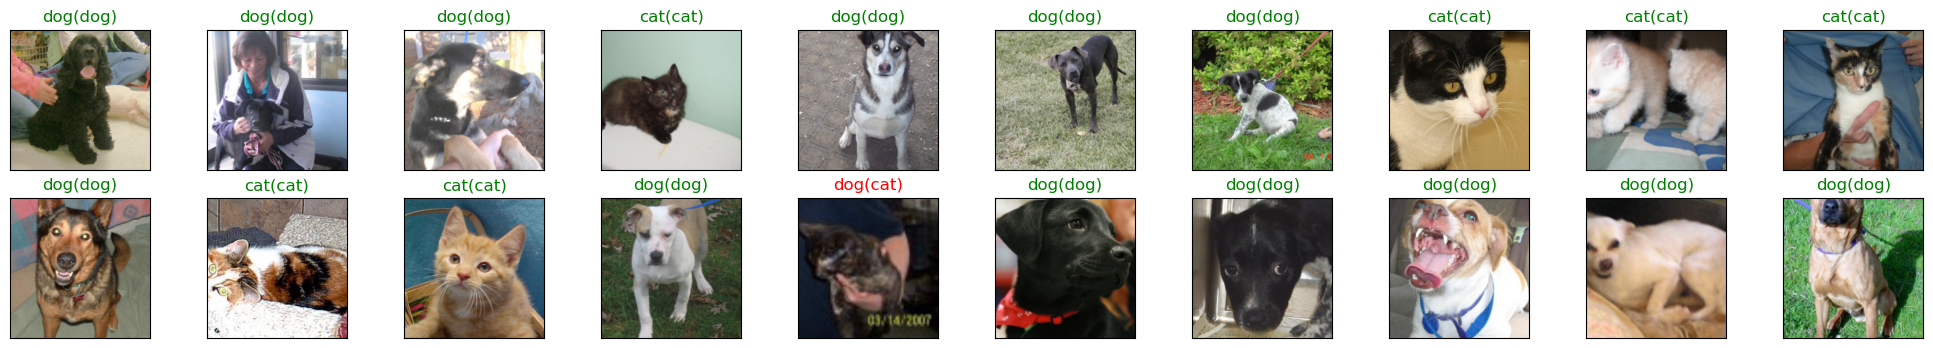

<Figure size 640x480 with 0 Axes>

In [43]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = dataiter.next()
pred = model(images)
_, preds = torch.max(pred, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f'{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})', color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)